# バギング

In [116]:
# 定型ライブラリ読み込み
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import japanize_matplotlib
import scipy
from scipy import stats
from numpy.random import randn
from numpy.random import randint
import copy
import statistics

In [117]:
## 数式表示用
import sympy
sympy.init_printing()
from IPython.display import Math

## 損失関数を定義

In [118]:
## check
y = [np.random.randint(10) for i in range(30)]
print(y)
print(set(y))                   # setでユニークな要素を抽出
freq_ = [y.count(i) for i in set(y)]    # countで各要素数をカウント
print(freq_)
print(max(freq_))  # 最も多い要素の個数を出力
print(mode(y))

[8, 5, 3, 1, 4, 3, 5, 6, 1, 5, 7, 0, 5, 4, 5, 0, 1, 9, 9, 2, 5, 9, 6, 9, 7, 9, 4, 7, 4, 6]
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
[2, 3, 1, 2, 4, 6, 3, 3, 1, 5]
6
6


In [119]:
##　二乗誤差
def sq_loss(y):
    if len(y) == 0:
        return 0
    else:
        y_bar = np.mean(y)
        return np.linalg.norm(y-y_bar)**2  # L2ノルムを計算し二乗している

In [120]:
## 頻度
### 各要素の頻度を算出
def freq(y):
    y = list(y)
    return [y.count(i) for i in set(y)]

In [121]:
## 最頻値
def mode(y):
    n = len(y)
    if n == 0:
        return 0
    return max(freq(y))

In [122]:
# 誤り数
def mis_match(y):
    return len(y) - mode(y)

In [123]:
display(Math(r'G_j := \sum_{k=1}^K \hat{p}_{j,k}(1-\hat{p}_{j,k})'))

<IPython.core.display.Math object>

In [124]:
# Gini
def gini(y):
    n = len(y)
    if n == 0:
        return 0
    fr = freq
    return sum([fr[i]/n * (n - fr[i]) for i in range(len(fr))])

In [125]:
display(Math(r'D_j := -\sum_{k=1}^K \hat{p}_{j,k}log\hat{p}_{j,k}'))

<IPython.core.display.Math object>

In [126]:
# Entropy
def entropy(y):
    n = len(y)
    if n == 0:
        return 0
    freq = [y.count(i) for i in set(y)]
    return np.sum([-freq[i] * np.log(freq[i]/n) for i in range(len(freq))])

In [136]:
def mode_max(y):
    if len(y) == 0:
        return -np.inf
    count = np.bincount(y)
    return np.argmax(count)

## 実行用の関数を定義

In [128]:
# 枝の分割
# 総当たり計算を実施
    # 1. 各変数それぞれに対して
    # 2. あるデータiを選択したときに
    # 3. データiを閾値としてそれより小さいものをleft,以上をrightに格納
    # 4. 分割したときの損失関数を算出
    # 5. 損失関数が過去最少であった場合、閾値とデータ集合を更新
def branch(x, y, S, rf = 0):
    # x:入力データ
    # y:ターゲットデータ
    # S:変数jにおける全データを格納
    # rf:ランダムフォレストの実施の有無？
    if rf == 0:
        m = x.shape[1]   # mに変数の個数を格納
    if x.shape[0] == 0:  # データがないとき？
        return([0,0,0,0,0,0,0])
    
    #print(S)
    
    best_score = np.inf  # スコアをinfに設定し、最小値を探す
    
    for j in range(x.shape[1]):     # 変数の数だけループ
        for i in S:                 # 後で出てくるコードでSにpoppedを格納している popはオプションなしで指定した配列の最後の要素を取り出す
            left = []; right = []   # 枝の左右を初期化、left,rightはそれぞれの枝に入ったindexのリストである
            for k in S:
                if x[k,j] < x[i,j]:  # 枝の左右への振り分け j番目の変数におけるi番目のデータを閾値としたときの振り分けを実施
                    left.append(k)   # 左に入ったデータのindexのリストに新たにindexを追加
                else:
                    right.append(k)  # 右に入ったデータのindexのリストに新たにindexを追加
            left_score = f(y[left])           # 左側の損失関数を計算
            right_score = f(y[right])         # 右側の損失関数を計算
            score = left_score + right_score  # 合計値をスコアとする
            
            if score < best_score:                                      # スコアが過去のものより良い場合
                best_score = score                                      # スコアの最小値を更新
                i_1 = i; j_1 = j                                        # スコアが前回よりも小さい場合の閾値iと変数jのindexを格納
                left_1 = left; right_1 = right                          # 分割されたデータ集合left,rightのindexを格納
                left_score_1 = left_score; right_score_1 = right_score  # left,rightそれぞれの現時点での最小値を格納
                
    return [i_1, j_1, left_1, right_1, best_score, left_score_1, right_score_1]  # 返却

In [129]:
# データスタック
    # データ格納用にクラスを利用
class Stack:
    def __init__(self, parent, set, score):
        self.parent = parent   # 親ノードの番号
        self.set = set         # データのindexリスト
        self.score = score     # 損失関数
        
# ノード
    # データ格納用にクラスを利用
class Node:
    def __init__(self, parent, j, th, set):
        # parent:親ノードの番号
        # j:自身のノード番号
        # th:分岐の際の閾値
        # set:ノード内のデータ集合のindexリスト
        self.parent = parent
        self.j = j
        self.th = th
        self.set = set

In [130]:
# 枝を伸ばす
def dt(x, y, alpha = 0, n_min = 1, rf = 0):
    # x:入力データ
    # y:ターゲットデータ
    # alpha:後で利用
    # n_min:各ノードにおけるデータ集合の最小値
    # rf:ランダムフォレストの実施の有無？
    if rf == 0:
        m = x.shape[1]
    
    stack = [Stack(0, list(range(x.shape[0])), f(y))]   # stackを初期化
    node = []   # nodeを初期化
    k = -1      # kを初期化
    
    # stackに何かしらデータが残っている間のループ
    while len(stack) > 0:
        popped = stack.pop()   # stackの最後のデータを取り出してpoppedに格納
        #print(popped.parent, popped.score, popped.set)

        k = k + 1
        i, j, left, right, score, left_score, right_score = branch(x, y, popped.set, rf)  # 枝の分割を計算 Sにはpopped.setを入れる
        if popped.score - score < alpha or len(popped.set) < n_min or len(left) == 0 or len(right) == 0:
            # 以下の条件を満たすとき、枝をそこで止める
            ## 1. 一回前とのスコアの差分が閾値alphaより小さい
            ## 2. ノードのデータ集合数がn_minより小さい
            ## 3. 左の枝が空集合
            ## 4. 右の枝が空集合
            node.append(Node(popped.parent, -1, 0, popped.set))
        else:
            node.append(Node(popped.parent, j, x[i,j], popped.set))
            stack.append(Stack(k, right, right_score))
            stack.append(Stack(k, left, left_score))
    ### 枝を伸ばす処理はここまで
    
    # ノードの分岐構造をデータにする
    for h in range(k, -1, -1):
        # kは枝の数
        # 各ノードにleft, rightを設定する、そのための初期化
        node[h].left = 0
        node[h].right = 0

    for h in range(k, 0, -1):  # kから降順で最後の値の一つ手前まで
        pa = node[h].parent       # node[h]の親ノードをpaに格納
        #print(h, pa)
        if node[pa].right == 0:   # node[h]の親ノードの右側にまだ値が格納されていない場合
            node[pa].right = h   # node[h]をその親ノードのrightに格納
        else:                     # そうでない場合
            node[pa].left = h    # node[h]をその親ノードのleftに格納
        #print(h, pa, node[pa].right, node[pa].left)
    
    # 
    if f == sq_loss:      # 損失関数を二乗誤差にした場合の処理
        g = np.mean       # 平均値を引数に与える関数とする
    else:
        g = mode_max      # 中央値を引数に与える関数とする
    for h in range(k+1):
        if node[h].j == -1:    # ノードが枝分かれしていない場合
            node[h].center = g(y[node[h].set])    # そのノードの集合におけるターゲットの平均もしくは最頻値をそのノードのcenterとする
        else:
            node[h].center = 0                    # ノードが枝分かれしている場合はcenterを決めずとする
            
    return node

In [131]:
from igraph import *
def draw_graph(node):
    r = len(node)
    col = []
    for h in range(r):
        col.append(node[h].j)
    colorlist = ['#ffffff','#fff8ff','#fcf9ce','#d6fada','#d7ffff','#d9f2f8','#fac8be','#ffebff','#ffffe0','#fdf5e6','#fac8be','#f8ecd5','#ee82ee']
    color = [colorlist[col[i]] for i in range(r)]
    edge = []
    for h in range(1,r):
        edge.append([node[h].parent,h])
        g = Graph(edges = edge, directed = True)
        layout = g.layout_reingold_tilford(root = [0])
    out = plot(g,
               vertex_size = 15,
               layout = layout,
               bbox = (300, 300),
               vertex_label = list(range(r)),
               vertex_color = color)
    return out

## バギングの実行

In [132]:
from sklearn.datasets import load_boston
import pandas as pd

In [133]:
n = 200                       # データ数
p = 5                         # 変数数
X = np.random.randn(n, p)     # 入力データを乱数で生成
beta = randn(p)               # betaを乱数で生成

Y = np.array(np.abs(np.dot(X, beta) + randn(n)), dtype = np.int64)  # yを生成、Xβ+εの形
f = mis_match  # 損失関数を誤り率にする
node_seq = []

In [134]:
print(Y)

[0 1 0 4 0 0 2 3 1 1 0 2 0 2 2 1 2 0 0 0 4 1 0 0 2 2 1 0 2 3 1 1 0 2 1 2 0
 0 2 2 1 1 1 0 0 0 1 1 0 0 0 0 2 0 2 0 0 1 1 1 1 4 3 0 0 1 2 0 0 0 2 2 2 4
 1 1 0 1 0 0 0 3 1 2 1 2 0 0 0 3 1 0 1 0 0 1 1 0 0 1 1 3 1 1 0 0 1 0 2 0 1
 2 2 2 0 0 1 1 0 1 0 1 1 0 2 1 0 3 0 3 2 3 0 0 1 2 0 0 1 0 0 1 2 0 1 0 1 1
 1 3 1 0 0 0 3 1 2 3 3 2 0 0 1 1 0 5 2 0 2 1 1 2 2 2 1 0 1 1 2 1 2 1 1 0 1
 0 1 2 0 1 0 0 1 3 0 3 1 1 0 1]


In [137]:
for h in range(8):
    index = np.random.choice(n, n, replace = True)
    x = X[index, :]
    y = Y[index]
    node_seq.append(dt(x, y, n_min = 6))

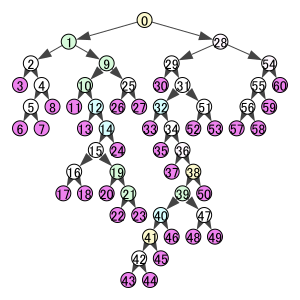

In [138]:
draw_graph(node_seq[0])

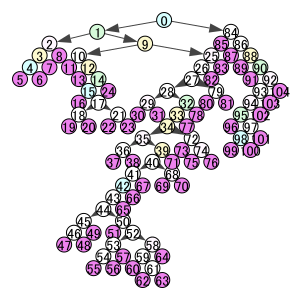

In [139]:
draw_graph(node_seq[1])